<a href="https://colab.research.google.com/github/praseedm/Advance-AI/blob/master/Train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# clone git repo for data
! git clone https://github.com/praseedm/Intel-MobileODT-CervicalCancerScreening.git

Cloning into 'Intel-MobileODT-CervicalCancerScreening'...
remote: Enumerating objects: 2013, done.
remote: Counting objects: 100% (2013/2013), done.
remote: Compressing objects: 100% (2008/2008), done.
remote: Total 2013 (delta 4), reused 2013 (delta 4), pack-reused 0
Receiving objects: 100% (2013/2013), 20.36 MiB | 22.47 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [4]:
%cd Intel-MobileODT-CervicalCancerScreening

/content/Intel-MobileODT-CervicalCancerScreening


## Import Libraries

In [65]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
import pandas as pd
from tqdm import tqdm

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Dataset

Resized train data is available inside data/resized/train 

Resized test data is available inside data/resized/test

In [17]:
train_data_root_dir = pathlib.Path('./data/resized/train')

In [18]:
train_image_count = len(list(train_data_root_dir.glob('*/*.jpg')))
print(train_image_count)

1480


## Constants

In [16]:
BATCH_SIZE = 32
IMAGE_SIZE = (180,180)

## Generate Train, Validation data

In [19]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_root_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

Found 1480 files belonging to 3 classes.
Using 1184 files for training.


In [20]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_root_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

Found 1480 files belonging to 3 classes.
Using 296 files for validation.


In [21]:
class_names = train_ds.class_names
print(class_names)

['Type_1', 'Type_2', 'Type_3']


## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [27]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Normalize data

Normalize RGB values from `[0,255]` to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`.

In [28]:
normalization_layer = layers.Rescaling(1./255)

## Create Model

In [43]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [44]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [45]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)       

## Train Model

In [46]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
37/37 [==============================] - 35s 923ms/step - loss: 1.2359 - accuracy: 0.4840 - val_loss: 0.9549 - val_accuracy: 0.5507
Epoch 2/10
37/37 [==============================] - 34s 923ms/step - loss: 0.9382 - accuracy: 0.5431 - val_loss: 0.9226 - val_accuracy: 0.5676
Epoch 3/10
37/37 [==============================] - 34s 915ms/step - loss: 0.8683 - accuracy: 0.5769 - val_loss: 0.8709 - val_accuracy: 0.6250
Epoch 4/10
37/37 [==============================] - 34s 929ms/step - loss: 0.8107 - accuracy: 0.6191 - val_loss: 0.9245 - val_accuracy: 0.4966
Epoch 5/10
37/37 [==============================] - 34s 923ms/step - loss: 0.7811 - accuracy: 0.6275 - val_loss: 0.8996 - val_accuracy: 0.5676
Epoch 6/10
37/37 [==============================] - 34s 932ms/step - loss: 0.6948 - accuracy: 0.6774 - val_loss: 0.9720 - val_accuracy: 0.5507
Epoch 7/10
37/37 [==============================] - 34s 919ms/step - loss: 0.6263 - accuracy: 0.7272 - val_loss: 1.0003 - val_accuracy: 0.5743

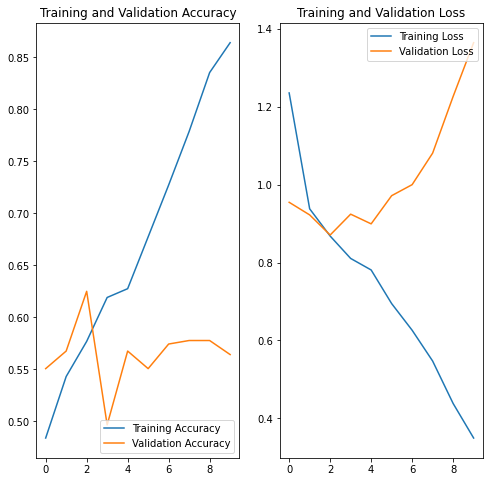

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Generate Submission file

In [54]:
def run_prediction(img_path, model):
  img = tf.keras.utils.load_img(img_path, target_size=IMAGE_SIZE)
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  return score.numpy()

In [59]:
run_prediction(img_path='./data/resized/test/1.jpg',model=model)

array([0.00763862, 0.14841202, 0.8439493 ], dtype=float32)

In [66]:
def generate_submission_file(test_data_dir, sample_submission_file_path, model, output_file_path):
  test_data_files =  list(pathlib.Path(test_data_dir).glob('*.jpg'))
  print(f"Number of test files {len(test_data_files)}")
  test_data_file_name_map = {file.name: file for file in test_data_files}
  print(f"Number of element in file name map : {len(test_data_file_name_map)}")

  sample_submission_df = pd.read_csv(sample_submission_file_path)
  submission_list = []
  for _,row in tqdm(sample_submission_df.iterrows()):
    file_name = row['image_name']
    file_path = test_data_file_name_map[file_name]

    scores = run_prediction(img_path=file_path, model=model)
    submission_list.append((file_name, scores[0], scores[1], scores[2]))

  submission_df = pd.DataFrame(submission_list, columns=sample_submission_df.columns)
  assert(sample_submission_df.shape == submission_df.shape)
  submission_df.to_csv(output_file_path, index=None)

In [67]:
generate_submission_file(test_data_dir='./data/resized/test',sample_submission_file_path='./sample_submission.csv',model=model,output_file_path='./test_submission.csv')

Number of test files 512
Number of element in file name map : 512


512it [00:34, 14.68it/s]
